# ラット自由行動下の軌跡のシミュレーション

ラットが自由行動下において箱の中を探索する際の軌跡をシミュレーションする {cite:p}`Raudies2012-gp`．これまでと異なり，現象論的に運動を生成する．場所細胞・格子細胞等自己位置と神経活動が相関する細胞のシミュレーションにおいて用いられる．

In [1]:
using PyPlot, LinearAlgebra, Random, Distributions
rc("axes.spines", top=false, right=false)

In [2]:
box_width, box_height = 0.8, 0.8; # Width and height of environment (meters)
perimeter_dist = 0.03  # Perimeter region distance to walls (meters)
σv = 0.13              # Forward velocity Rayleigh distribution scale (m/sec)
μω = 0.0               # Rotation velocity Gaussian distribution mean (rad/sec)
σω = (330 / 360) * 2π  # Rotation velocity Gaussian distribution standard deviation (rad/sec)
dt = 0.02              # Simulation-step time increment (seconds)
decel_rate = 0.25;     # velocity reduction factor when located in the perimeter

並進速度をレイリー分布，回転速度を正規分布に従うようにランダムサンプリングする．壁の接ベクトルとラットの距離を`dist_wall`, 壁の法線ベクトルとラットの頭方向の角度の差を`angle_wall`とする．なお，壁とはラットの自己速度ベクトルと壁全体との交点である．

- ラットの自己速度ベクトルと壁全体との交点を求める．
- 交点の接ベクトルと法線ベクトルを求める．
- 接ベクトルとの距離を`dist_wall`とする．
- 法線ベクトルと成す角を`angle_wall`とする．

In [3]:
function min_dist_angle(pos, head_dir, wall_type="square")
    x, y = pos
    if wall_type == "square"
        dists = [box_width/2-x, box_height/2-y, box_width/2+x, box_height/2+y]
        dist_wall, nearest_wall = findmin(dists)
        angle_wall = mod(head_dir - (nearest_wall-1)*π/2 + π, 2π) - π
    elseif wall_type == "circle"
        dist_wall = box_width/2 - sqrt(x^2 + y^2)
        angle_wall = mod(head_dir - atan(y, x) + π, 2π) - π
    else
        @warn "'wall_type' must be 'square' or 'circle'"
    end 
    return dist_wall, angle_wall
end;

In [4]:
function generate_trajectory(num_steps, wall_type)
    # store arrays
    position, velocity = zeros(num_steps, 2), zeros(num_steps, 2)
    head_dir = zeros(num_steps) # head direction
    speed = rand(Rayleigh(σv), num_steps) # Forward speed
    random_turn = rand(Normal(μω, σω), num_steps) * dt

    # initial values
    head_dir[1] = rand() * 2π
    position[1, :] = (rand(2) .-0.5) .* ([box_width, box_height] .- perimeter_dist)
    
    # iteration of trajectory
    for t in 1:num_steps-1
        turn_angle = random_turn[t]
        dist_wall, angle_wall = min_dist_angle(position[t, :], head_dir[t], wall_type)
        if (dist_wall < perimeter_dist) && (abs(angle_wall) < π/2) # avoid wall
            speed[t] *= decel_rate # deceleration
            turn_angle += sign(angle_wall) * (π/2 - abs(angle_wall))
        end
        velocity[t, :] = speed[t] * [cos(head_dir[t]), sin(head_dir[t])]
        position[t+1, :] = position[t, :] + velocity[t, :] * dt
        head_dir[t+1] = mod(head_dir[t] + turn_angle, 2π) # turn, 
    end
    return position, velocity, speed, head_dir
end;

5分間のシミュレーションを行う．

In [5]:
T = 300 # simulation time (sec)
num_steps = round(Int, T/dt)
wall_types = ["square", "circle"]
positions = zeros(2, num_steps, 2)
for i in 1:2
    positions[i, :, :], _, _, _ =  generate_trajectory(num_steps, wall_types[i]);
end

黒点から始まり，赤点に終わる．

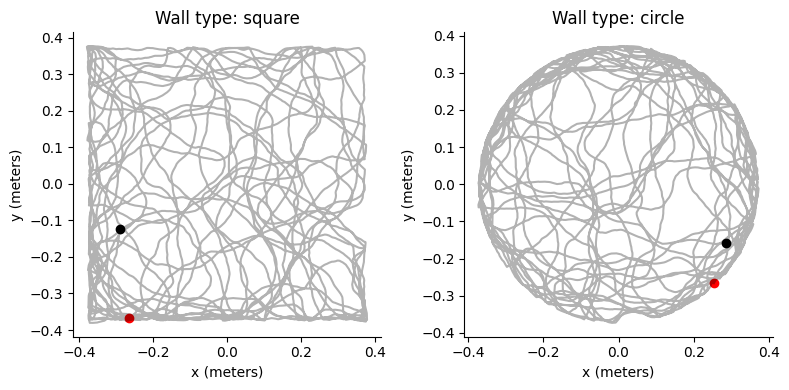

In [6]:
figure(figsize=(8, 4))
for i in 1:2
    subplot(1,2,i)
    title("Wall type: "*wall_types[i])
    xlabel("x (meters)"); ylabel("y (meters)")
    plot(positions[i, 1, 1], positions[i, 1, 2], "ko", label="Start")
    plot(positions[i, end, 1], positions[i, end, 2], "ro", label="Goal")
    plot(positions[i, :, 1], positions[i, :, 2], color="k", alpha=0.3)
end
tight_layout()

## 参考文献
```{bibliography}
:filter: docname in docnames
```